## Imports

In [168]:
!pip install arabert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [169]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [243]:
import pandas as pd 
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from arabert.preprocess import ArabertPreprocessor
from tensorflow.keras.layers import Dense , Embedding, Flatten, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Load Datasets

In [171]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [172]:
# load arabic names
real_arabic_names = pd.read_csv('drive/MyDrive/Names web dataset/Arabic_names.csv')
# load male names
male = pd.read_csv('drive/MyDrive/Names web dataset/mnames.txt', sep='\n', header=None, names=['Name'])
# load female names
female = pd.read_csv('drive/MyDrive/Names web dataset/fnames.txt', sep='\n', header=None, names=['Name'])

In [173]:
# view first rows of real arabic names
real_arabic_names.head()

,Name,Gender
0,ابتسام,F
1,ابتهاج,F
2,ابتهال,F
3,اجتهاد,F
4,ازدهار,F


In [174]:
# view last 5 rows of arabic names
real_arabic_names.tail()

,Name,Gender
1400,وهبة,M
1401,ياسر,M
1402,يحيى,M
1403,يزيد,M
1404,يعقوب,M


In [175]:
# view first 5 rows of male names
male.head()

,Name
0,أبان
1,أبو بكر
2,أبو حمزة
3,أحد
4,أحمد


In [176]:
# view last 5 rows of male names
male.tail()

,Name
635,وفيق
636,وهاب
637,وهبة
638,ياسر
639,يحيى


In [177]:
# view first 5 rows of female names
female.head()

,Name
0,آيات
1,آلاء
2,آمال
3,آمنة
4,آيات


In [178]:
# view last 5 rows of female names
female.tail()

,Name
411,وميض
412,وهبة
413,يارا
414,ياسمين
415,يسرا


In [179]:
# add gender column to male and female names
male['Gender'] = 'M'
female['Gender'] = 'F'

In [180]:
# merge male names with female names
names = pd.concat([male,female])
# merge the result with arabic names
real_names = pd.concat([real_arabic_names,names])

In [181]:
# add label column to the arabic names datasets that identifies that these names are real names
real_names['Label'] = 'Real'

In [182]:
# shape of the result of merging all real arabic names datasets
real_names.shape

(2461, 3)

In [183]:
def check_duplicates(data, text):
  df = data
  # check to see if there is duplicates in rows
  print('Number of duplicated names are: ', df['Name'].duplicated().sum())
  # create mask
  duplicated_names_mask_fake = df['Name'].duplicated()
  # new arabic names dataframe without any duplicated names
  df = df[~ duplicated_names_mask_fake]
  print('The shape of ', text, 'after deleting duplicates is:', df.shape)
  # reset index
  df = df.reset_index(drop=True)
  return df

In [184]:
# check and remove duplicates
names = check_duplicates(real_names, 'real names')

Number of duplicated names are:  909
The shape of  real names after deleting duplicates is: (1552, 3)


In [185]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1552 non-null   object
 1   Gender  1552 non-null   object
 2   Label   1552 non-null   object
dtypes: object(3)
memory usage: 36.5+ KB


In [186]:
names.describe()

,Name,Gender,Label
count,1552,1552,1552
unique,1552,2,1
top,ابتسام,M,Real
freq,1,929,1552


## Data generation

In [187]:
arabic_alphabet = ['ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 
                     'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'أ', 'ؤ', 
                     'ة', 'آ', 'ء', 'ئ', 'إ']

In [188]:
class DataGenerator:
    
    def __init__(self, alpha):
        self.alphabet = alpha
    
    def generate(self, mode, num_of_words, name, gender):
        generated_data = dict()
        generated_names = []
        generated_gender = []
        generated_label = ['Fake'] * num_of_words
        i = 0
        while i < num_of_words:
            random_index = random.randint(0, (len(name) - 1))
            if mode == 'replace_char':
                alpha_random_index = random.randint(0, (len(self.alphabet) - 1))
                fake_name = name.replace(name[random_index], self.alphabet[alpha_random_index])
            elif mode == 'delete_char':
                fake_name = name.replace(name[random_index], "")
            elif mode == 'add_char':
                alpha_random_index = random.randint(0, (len(self.alphabet) - 1))
                fake_name = name[:random_index] + self.alphabet[alpha_random_index] + name[random_index:]
            if fake_name in generated_names:
                continue
            generated_names.append(fake_name)
            generated_gender.append(gender)
            i = i + 1
        generated_data['Name'] = generated_names
        generated_data['Gender'] = generated_gender
        generated_data['Label'] = generated_label        
        return generated_data
    
    def generate_full_name(self, mode, data, num_of_names):
        generated_data = dict()
        generated_first_last_names = []
        generated_full_names = []
        generated_gender = []
        generated_label = []
        # first name and second name
        names = list(data['Name'].values)
        genders = list(data['Gender'].values)
        for name, gender in zip(names, genders):
          counter1 = 0
          while True:
            if counter1 >= num_of_names:
              break
            index2 = random.randint(0,(len(names) - 1))
            if genders[index2] == 'F':
              continue
            first_last_name = name + ' ' + names[index2]
            generated_first_last_names.append(first_last_name)
            generated_gender.append(gender)
            if mode == 'Real':
              generated_label.append('Correct')
            elif mode == 'Fake':
              generated_label.append('Incorrect')
            counter1 = counter1 + 1
        # full name
        for name in  generated_first_last_names:
          while True:
            index2 = random.randint(0,(len(names) - 1))
            if genders[index2] == 'F':
              continue
            else:
              break
          full_name = name + ' ' + names[index2]
          generated_full_names.append(full_name)
        generated_data['Name'] = generated_full_names
        generated_data['Gender'] = generated_gender
        generated_data['Label'] = generated_label  
        return pd.DataFrame.from_dict(generated_data)

In [189]:
# create object of the DataGenerator class
generator = DataGenerator(arabic_alphabet)

For each name in the **_Arabic Names Dataset_**, we will generate **two** fake names by deleting a random character from the original name at random position, then generate **six** fake names by adding a  wrong character to the original name at random position, and **four** fake names by replacing a random single character from the original name with another wrong random character

**IMPORTANT NOTE**, we will not consider all possibilities of generating a fake name from an original name, as this will lead us to huge fake names maybe reach to more than **500,000!** fake name, So it will be enough to generate **12x** fake names from the real names dataset

In [190]:
# generate 2 fake names by delete a char
f_names_deleted_char = names.apply(lambda x: generator.generate(mode='delete_char', num_of_words=2, 
                                                                name=x['Name'], gender=x['Gender']), axis=1)
# generate 4 fake names by replace a char
f_names_replaced_char = names.apply(lambda x: generator.generate(mode='replace_char', num_of_words=4, 
                                                                name=x['Name'], gender=x['Gender']), axis=1)
# generate 6 fake names by adding a wrong char
f_names_adding_wrong_char = names.apply(lambda x: generator.generate(mode='add_char', num_of_words=6, 
                                                                name=x['Name'], gender=x['Gender']), axis=1)

In [191]:
# this function is used to re-represent the output of the generator to make it one dictionary instead of a 
# dictionary for each name, to convert the dictionary to a dataframe
def one_dict(multi_dict):
    dic = dict()
    name = []
    gender = []
    label = []
    for row in multi_dict:
        for names in row['Name']:
            name.append(names)
        for genders in row['Gender']:
            gender.append(genders)
        for labels in row['Label']:
            label.append(labels)  
    dic['Name'] = name
    dic['Gender'] = gender
    dic['Label'] = label
    return dic

In [192]:
# convert the output of the generator to one dictionary containing all names
deleted_char_dict = one_dict(f_names_deleted_char)
replaced_char_dict = one_dict(f_names_replaced_char)
added_char_dcit = one_dict(f_names_adding_wrong_char)
# convert the dictionaries into dataframe form
deleted_char_df = pd.DataFrame.from_dict(deleted_char_dict)
replaced_char_df = pd.DataFrame.from_dict(replaced_char_dict)
added_char_df = pd.DataFrame.from_dict(added_char_dcit)
# concatenate the 3 dataframe to form the Fake Names Dataset
f_names = pd.concat([added_char_df, replaced_char_df, deleted_char_df],ignore_index=True)

In [193]:
# view first 5 rows of fake names
f_names.head()

,Name,Gender,Label
0,ظابتسام,F,Fake
1,اببتسام,F,Fake
2,ابتسأام,F,Fake
3,ابتسزام,F,Fake
4,زابتسام,F,Fake


In [194]:
# view last 5 rows of fake names
f_names.tail()

,Name,Gender,Label
18619,ناحة,F,Fake
18620,ينا,F,Fake
18621,ميا,F,Fake
18622,نصاة,F,Fake
18623,صاحة,F,Fake


In [195]:
f_names.shape

(18624, 3)

In [196]:
f_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18624 entries, 0 to 18623
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    18624 non-null  object
 1   Gender  18624 non-null  object
 2   Label   18624 non-null  object
dtypes: object(3)
memory usage: 436.6+ KB


In [197]:
f_names.describe()

,Name,Gender,Label
count,18624,18624,18624
unique,17878,2,1
top,مير,M,Fake
freq,7,11148,18624


In [198]:
# check and remove duplicates
f_names2 = check_duplicates(f_names, 'fake names')

Number of duplicated names are:  746
The shape of  fake names after deleting duplicates is: (17878, 3)


In [199]:
# check to see if there is a fake name exist in real names
# False indicates that this name will be deleted from the fake names dataset
# True indicates that this name will remain exist in the fake names dataset
fake_real_mask = [False if name in names['Name'] else True for name in f_names2['Name']]
print('Number of fake names that exist in real arabic names', len([fake_real_mask == False]))
fake_names = f_names2[fake_real_mask]

Number of fake names that exist in real arabic names 1


We have our real arabic names dataset and generated fake names dataset from our real arabic names, We will now create a **Full Name Dataset** consists of 3 names separated by space

We will create **Two Datasets**:
1. The first is full names with real arabic names, by generating **random 162 name** for each name in the real arabic names dataset
2. the second is full names with fake arabic names, by generating **random 15 name** for each name in the fake arabic names dataset

There is a difference in the number of random names generations in the two datasets, and that is because if we make equal number of names, that will lead to **Imbalanced Dataset Problem**, as now the fake full names will be huge data and maybe more than **10x** of real full names also the memory will run out if we do so, so the above numbers generated for each dataset will be enough and the two datasets will be **Balanced**

In [200]:
# full names with real arabic names
full_names_real = generator.generate_full_name(mode='Real', data=names,num_of_names=162)
# full names with fake arabic names
full_names_fake = generator.generate_full_name(mode='Fake', data=fake_names,num_of_names=15)

In [201]:
# combine the two dataset together into one
full_names = pd.concat([full_names_real,full_names_fake])
# shuffle the data
full_names = full_names.sample(frac=1)
# reset index
full_names = full_names.reset_index(drop=True)

In [202]:
# view first 5 rows of the full_names dataset
full_names.head()

,Name,Gender,Label
0,عهميد ظمضر جهاأ,M,Incorrect
1,رنيبة محجد ةمسلمة,F,Incorrect
2,فخري مطاع عزب,M,Correct
3,أنظام عايض شوقي,F,Correct
4,نوال سيف ثائر,F,Correct


In [203]:
# view last 5 rows of the full_names dataset
full_names.tail()

,Name,Gender,Label
519589,مبشر أجاويد سميح,M,Correct
519590,أخزم معاد أكثم,M,Correct
519591,سإحيم قحابس أعور,M,Incorrect
519592,فوزيهة داد مماجد,F,Incorrect
519593,باسق ستار طاهر,M,Correct


In [204]:
full_names.shape

(519594, 3)

In [205]:
full_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519594 entries, 0 to 519593
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Name    519594 non-null  object
 1   Gender  519594 non-null  object
 2   Label   519594 non-null  object
dtypes: object(3)
memory usage: 11.9+ MB


In [206]:
full_names.describe()

,Name,Gender,Label
count,519594,519594,519594
unique,519573,2,2
top,رمهاح فدوح راذئف,M,Incorrect
freq,2,309318,268170


In [207]:
# check and remove duplicates
full_names = check_duplicates(full_names, 'full names')

Number of duplicated names are:  21
The shape of  full names after deleting duplicates is: (519573, 3)


## Core Model

For the Core Model part i will use a **Pretrained Model** that is **AraBERT** and it is an Arabic pretrained language model based on Google's BERT architechture but for  Arabic Language Understanding

We will use the **Tokenizer** of **AraBERT** to convert our full names into tokens after that ids that represent each word to make data ready for my own Deep Learning Model

In [208]:
# load the model, tokenizer and preprocessor
model_name = 'aubmindlab/bert-base-arabertv02'
tokenizer =  AutoTokenizer.from_pretrained(model_name)
preprocessor = ArabertPreprocessor(model_name=model_name)

Prepare the data for the **Model**

In [209]:
# drop the gender column as it wouldn't be useful anymore
full_names = full_names.drop(columns=['Gender'])
# divide data into x that represents features and y that represent target
X = full_names.drop(columns=['Label'])
y = full_names[['Label']]
# divide the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [210]:
# reset index for all data
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

This method apply all transofrmation and preprocessing for the names data, as it converts it to **Tokens** and convert tokens into **IDs** and **Encodes** the labels of the data by converting them to **One Hot Encoding** return to us the data ready to be fed into my own Deep Learning Model

In [223]:
def transform_data(X,y):
  # apply preprocessor on the X data
  X = X['Name'].apply(lambda x: preprocessor.preprocess(x))
  # convert back to dataframe and reset_index
  X = pd.DataFrame(X,columns=['Name'])
  # tokenize X data
  X = [tokenizer.tokenize(name ,max_length=3, truncation=True) for name in X['Name'].tolist()]
  # convert tokens in X to ids
  X = [tokenizer.convert_tokens_to_ids(name) for name in X]
  # convert into numpy array
  X = np.array(X)
  # encode labels in y data
  y = pd.get_dummies(y['Label'])
  return X, y

In [212]:
# transofrm X_train and y_train data
X_train , y_train = transform_data(X_train,y_train)
# transform X_test and y_test data
X_test , y_test = transform_data(X_test,y_test)

Define my own **Model Architecture**

In [255]:
# hyperparameters
VOCAB_SIZE = 60000
MAX_LEN = 3
EMBEDDING_DIM = 16
HIDDEN_SIZE = 32
NUM_CLASSES = 2
BATCH_SIZE = 128
EPOCHS = 10
VAL_SLPIT = 0.15
OPTIMIZER = Adam()
LOSS = BinaryCrossentropy()
METRICS = ['accuracy']

In [256]:
# architecture
model = Sequential([
    Embedding(input_dim= VOCAB_SIZE, output_dim= EMBEDDING_DIM, input_length= MAX_LEN),
    GlobalAveragePooling1D(),
    Dense(units= HIDDEN_SIZE, activation = 'relu'),
    Dense(units= NUM_CLASSES, activation='softmax')
])

In [257]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 3, 16)             960000    
                                                                 
 global_average_pooling1d_13  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_32 (Dense)            (None, 32)                544       
                                                                 
 dense_33 (Dense)            (None, 2)                 66        
                                                                 
Total params: 960,610
Trainable params: 960,610
Non-trainable params: 0
_________________________________________________________________


In [258]:
# compile the model
model.compile(optimizer = OPTIMIZER, loss = LOSS,metrics= METRICS)
# Training...
history = model.fit(x= X_train,y= y_train, batch_size= BATCH_SIZE, epochs = EPOCHS, validation_split= VAL_SLPIT)

Epoch 1/10
2933/2933 [==============================] - 39s 13ms/step - loss: 0.1015 - accuracy: 0.9666 - val_loss: 0.0572 - val_accuracy: 0.9795
Epoch 2/10
2933/2933 [==============================] - 47s 16ms/step - loss: 0.0542 - accuracy: 0.9812 - val_loss: 0.0532 - val_accuracy: 0.9818
Epoch 3/10
2933/2933 [==============================] - 39s 13ms/step - loss: 0.0503 - accuracy: 0.9825 - val_loss: 0.0497 - val_accuracy: 0.9819
Epoch 4/10
2933/2933 [==============================] - 38s 13ms/step - loss: 0.0444 - accuracy: 0.9844 - val_loss: 0.0428 - val_accuracy: 0.9852
Epoch 5/10
2933/2933 [==============================] - 50s 17ms/step - loss: 0.0379 - accuracy: 0.9870 - val_loss: 0.0393 - val_accuracy: 0.9865
Epoch 6/10
2933/2933 [==============================] - 55s 19ms/step - loss: 0.0344 - accuracy: 0.9884 - val_loss: 0.0368 - val_accuracy: 0.9877
Epoch 7/10
2933/2933 [==============================] - 39s 13ms/step - loss: 0.0321 - accuracy: 0.9896 - val_loss: 0.0350 -

In [259]:
def plot_curves(history):
    title_loss = 'Model loss per epoch '
    title_accuracy = 'Model accuracy per epoch '
    fig , axis = plt.subplots(nrows=1, ncols=2)
    # dimensions of figure
    fig.set_figheight(6)
    fig.set_figwidth(14)
    # loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epoch = np.arange(150)
    # loss curve
    axis[0].plot(loss,label='Train')
    axis[0].plot(val_loss,label='Validation')
    axis[0].set_xlabel('epoch')
    axis[0].set_ylabel('loss')
    axis[0].set_title(title_loss)
    axis[0].legend()
    # accuracy curve
    axis[1].plot(accuracy, label='Train')
    axis[1].plot(val_accuracy, label='Validation')
    axis[1].set_xlabel('epoch')
    axis[1].set_ylabel('accuracy')
    axis[1].set_title(title_accuracy)
    axis[1].legend()


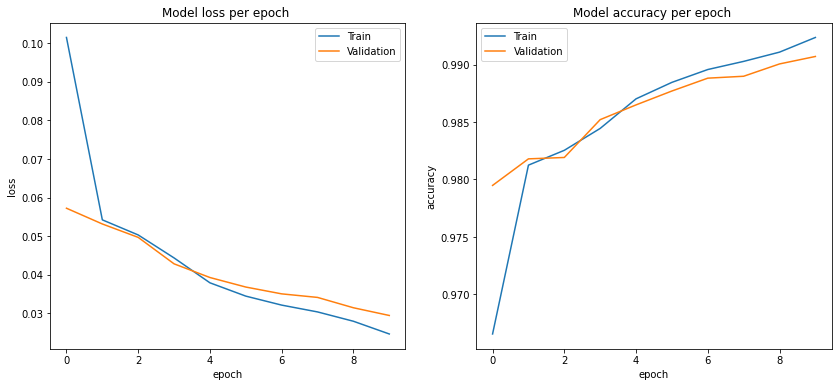

In [260]:
plot_curves(history)

Perform predictions and calculate the **accuarcy** on the Test Data to determine the performance of the model

In [261]:
def predictions(model, X_test, y_test):
  correct_pred = []
  incorrect_pred = []
  # perform predictions
  pred = model.predict(X_test)
  for x in pred:
    # this case means that the model predicts the full name is correct and its confidence is higher than the confidence of the full name being incorrect
    if x[0] > x[1]:
      correct_pred.append(1)
      incorrect_pred.append(0)
    # this case means that the model predicts the full name is incorrect and its confidence is higher than the confidence of the full name being correct
    elif x[1] > x[0]:
      incorrect_pred.append(1)
      correct_pred.append(0)
  # put predictions into a dictionary under two keys correct and incorrect
  y_pred = {'Correct': correct_pred, 'Incorrect': incorrect_pred}
  # convert predictions to dataframe
  y_pred = pd.DataFrame(y_pred, columns=['Correct','Incorrect'])
  acc = accuracy_score(y_test, y_pred)
  return acc

In [262]:
accuracy = predictions(model, X_test, y_test)
print('The accuracy of the model on Test Data is:', accuracy)

2436/2436 [==============================] - 3s 1ms/step
The accuracy of the model on Test Data is: 0.9908899609936358


Saving the Model 

In [267]:
saved_model_name = 'drive/MyDrive/name_verification_model.h5'
model.save(saved_model_name)